/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5


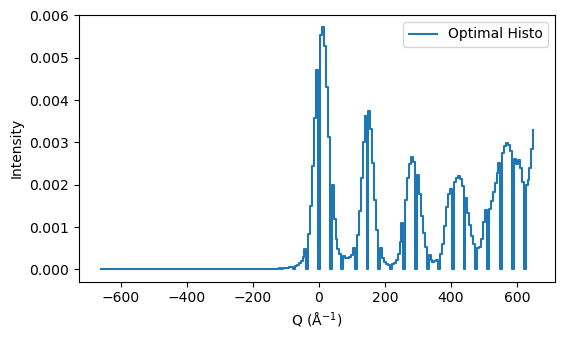

In [187]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

ema1.plot_histogram(loglog=False, log=False)



Least squares model function defined.


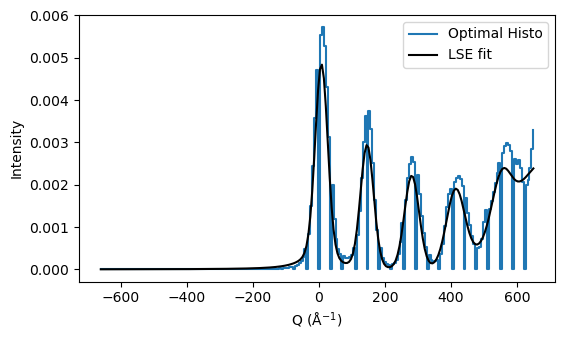

['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


In [188]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)

ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
ema1.plot_LSE_fit(loglog=False, log=False)

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_sigmas()
print(psigs)

detailed_fit_sigmas = psigs

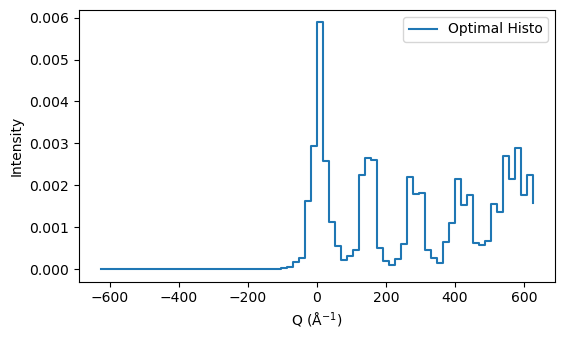

Calculating KDE


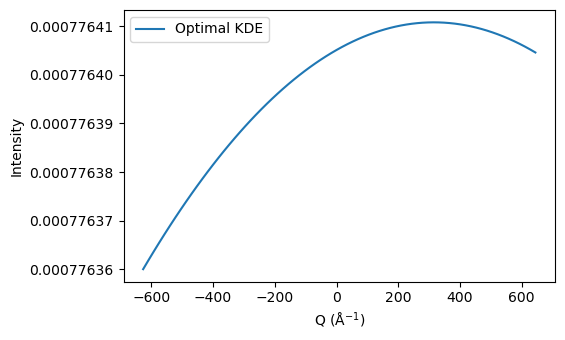

In [189]:
cpo = ema1.subsample(100000)
cpo.plot_histogram(loglog=False,log=False)
cpo.plot_kde(loglog=False,log=False)

Yeah OK I need to fix that KDE...!

In [190]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -100.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
    
    return result


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
 2.74781599e-01])

# Seed MCMC search with LSE fit
cpo.lse_fit()
cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
cpo.theta_seed = cpo.theta_seed[1:]

cpo.MCMC_fit()

MCMC launch
Burn in:


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 12.02it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:16<00:00, 12.20it/s]


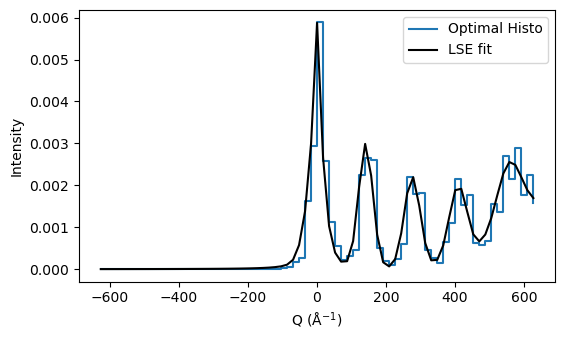

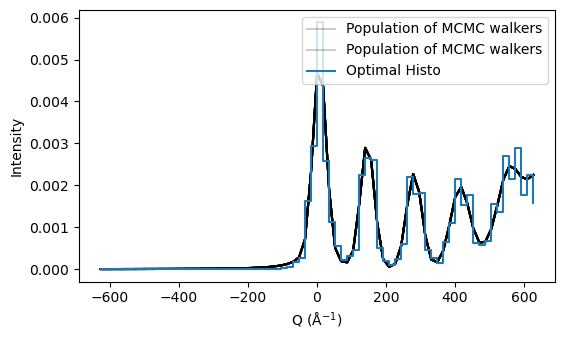

In [191]:
cpo.plot_LSE_fit(loglog=False, log=False)
cpo.plot_MCMC_fit(method="histo", loglog=False, log=False)

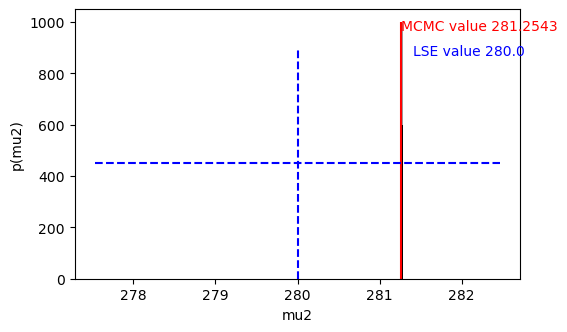

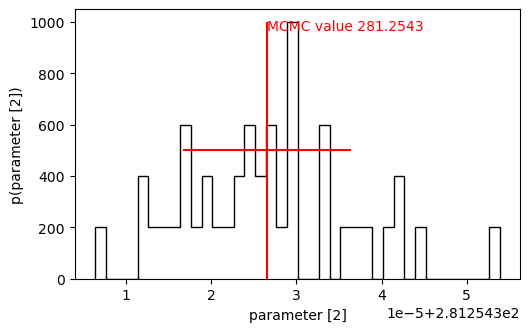

In [192]:
lookat=2
cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False)

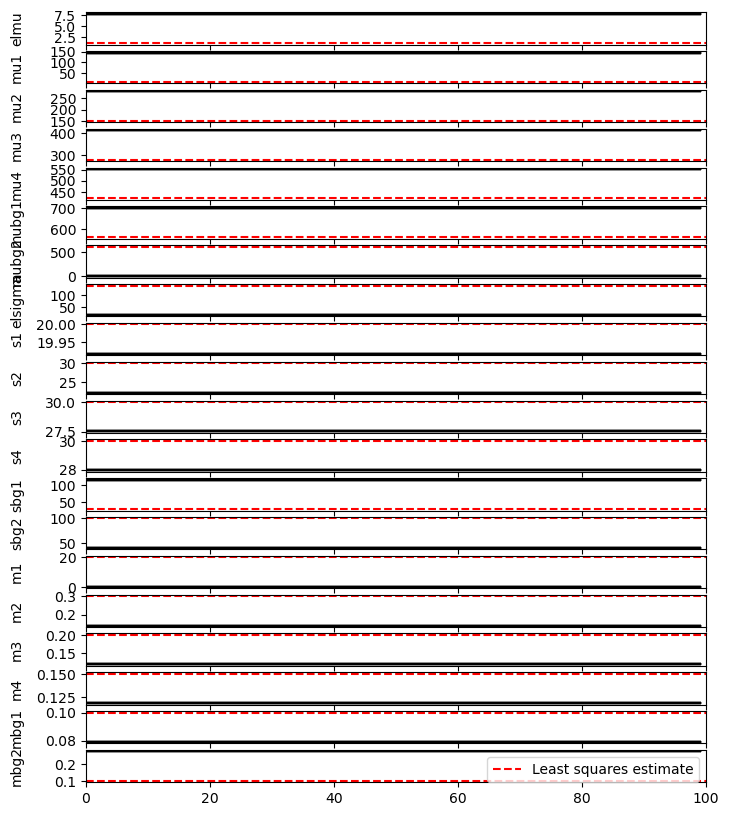

In [193]:
cpo.plot_MCMC_convergences()

In [198]:
mcparams, mcerr = cpo.get_MCMC_parameters()

import pandas
df = pandas.DataFrame({"LSE": detailed_fit_params[1:], "LSE_ERR": detailed_fit_sigmas[1:], "BAYES": mcparams, "BAYES_ERR": mcerr})
print(df)



           LSE       LSE_ERR       BAYES  BAYES_ERR
0     7.833200  6.774075e+00    7.833199   0.000008
1   145.695047  2.426087e+00  145.695047   0.000010
2   281.254328  3.351525e+00  281.254327   0.000010
3   414.035526  5.964785e+00  414.035529   0.000010
4   552.327378  1.224126e+01  552.327378   0.000010
5   699.999691  3.093372e+02  699.999691   0.000010
6     0.023019  3.625144e+01    0.023020   0.000010
7    18.642267  3.894493e+00   18.642268   0.000010
8    19.916509  2.562883e+00   19.916509   0.000010
9    22.106692  3.389970e+00   22.106692   0.000009
10   27.513671  7.332004e+00   27.513672   0.000010
11   27.961379  1.787876e+01   27.961379   0.000011
12  116.801601  5.138834e+13  116.801602   0.000010
13   40.281731  1.764929e+02   40.281728   0.000009
14    0.190420  2.181592e-01    0.190420   0.000009
15    0.140207  1.826001e-02    0.140205   0.000010
16    0.118191  1.602676e-02    0.118191   0.000011
17    0.118351  4.384656e-02    0.118353   0.000010
18    0.0789

I'm guessing if I were to monte-carlo sample the std. devs of the LSE analysis the error bars would not be that big, because the answers are very close to MCMC.